In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import Image
from IPython.core.display import HTML 
import datetime
import math


# Premise

We approach EDA from a perspective of an investor, whose interests are maximizing risk-adjusted returns. Here we will look at interest rate vs default rate, and then calculate a net adjusted annual return separated by the loan grade.

Next, we answer the question, are 36 month loans 


Lastly, we will build a model that can create a basket of investments that can outperform the market basket. These are the steps done and assumptions made.

    1. We first calculate the sharpe ratio using net adjusted return on all historical basket of loans. 
    2. We will build a regression model, using features chosen carefully through nested model testing, that will forecast the returns of all the loans in a validation dataset
    3. We will then use linear programming to set constraint and build a portfolio that maximizes the sharpe ratio with 10% of market liquidity
    4. We will then compare our model vs actual result to get a sense of whether we were able to outperform or not 

Additional analysis that can be done is accounting for changes in the risk free rate, and rebalancing of the portfolio year over year.

# Assumptions & Discussions

1. Funded Amount vs Funded Amount Inv: Where there are differences, lending tree stepped in to make up for the differences between loan amount and funed amount invested by investors. We will go ahead and use funded amount as a basis for all our analysis.
2. We assume all cash is deployed on year of x(has the most data) to reduce cash drag. We calculate IRR-> assuming we can reinvest at this rate 
3. Returns on the loans are most likely not normally distributed but a pool of randomly sampled loans should be

# Data Cleansing

In [ ]:
https://www.lendingclub.com/public/images/0180344/content/aboutNAR/NAR.png

In [129]:
Image(url= "https://www.lendingclub.com/public/images/0180344/content/aboutNAR/NAR.png")

As an investor, you want to get a good grasp of two things of any investments, risk and reward. This analyis will mainly focus on that. 

Dissecting the data to too many categorical values can 

First we calculat the default percentage, we will include the "does not meet..." rows as valid loans, and throw out rest of the data that we don't have complete information on.

###data call outs
You can't trade on information that is not there yet.... 


In [2]:
###data load
df = pd.read_csv('./data/loan.csv', low_memory=False)

In [3]:
###cleaning data 
df['last_pymnt_d']=pd.to_datetime(df.last_pymnt_d)
df['issue_d']=pd.to_datetime(df.issue_d)

In [4]:
###fill missing last_payments(no payments) with issue date, may want a separete column for this treatme
###This is for calculation of IRRs later
df['last_pymnt_d'].fillna(df.issue_d,inplace=True)

In [5]:
###Some pre-processing for ease of calculations
df['issue_yr'] = df.issue_d.dt.year
df['issue_mo']= df.issue_d.dt.month
df['last_pymnt_yr'] = df.last_pymnt_d.dt.year
df['last_pymnt_mo']= df.last_pymnt_d.dt.month

In [6]:
###filter to loans we have complete data only
searchfor = ['Fully Paid', 'Charged Off', 'Default']
df_filtered = df[df['loan_status'].str.contains('|'.join(searchfor))].query("term == ' 36 months' and issue_yr <=2012")

In [7]:
###default flag 
df_filtered['loan_status_flag'] = np.where(df_filtered['loan_status'].str.contains('Fully Paid') ,1,0)

### Overall Default Percentage

In [8]:
1- df_filtered['loan_status_flag'].mean()

0.12997142017682095

### Overall Interest Rate

In [9]:
df_filtered['int_rate'].mean()

12.033947888569795

In [10]:
### IRR Calculations
###calculate differences in months for total duration of the loan 
df_filtered['mo_diff'] = pd.to_numeric((df_filtered['last_pymnt_yr'] - 
                          df_filtered['issue_yr'])*12 + df['last_pymnt_mo'] -df['issue_mo'])
df_filtered['avg_pymnt'] = (df_filtered['total_pymnt']+ df_filtered['total_rec_late_fee'])/(df_filtered['mo_diff']-1)

In [101]:
x=[-10,1,1,2] 
y=[-10,2,2,2]
l=[]
l
l.append(1)
l

[1]

In [ ]:
##we calculate return using a pool of cash flows 
##avoids IRR's drastic treatment of negative IRR 
##automatically does weighted adjustment based on size of the loan
##we later can take many pools of data using functions built to effectively creat a derivative that is a pool of loans
##Pool of loans returns should be normally distributed, allowing us to do interesting analysis around normality
##and calculate things such as sharpe ratio
##More representative for institutional investors who will have a set of funds for an asset class and not
##investing in individual loans
##Diversification

In [108]:
def cash_flow(row,max_n):
    initial_invest = -row['funded_amnt'] 
    avg_payment = row['avg_pymnt'] or 0 
    num_payments = int(row['mo_diff']-1) 
    fully_paid =row['loan_status_flag'] or 0 
    recovery = row['recoveries'] or 0 
    chargeoff_fee = -row['collection_recovery_fee'] or 0 
    dummy_cfs = int(max_n - row['mo_diff'])
    return [initial_invest]+[avg_payment]*num_payments + [recovery+chargeoff_fee]+ [0]*dummy_cfs

In [142]:
def irr_pool(df):
    list_length = df['mo_diff'].max()
    cfs=[]
    for index, row in df.iterrows(): 
        cfs.append(cash_flow(row,list_length))
    result = [sum(x) for x in zip(*cfs)]
    return (np.irr(result)+1)**12 -1

In [134]:
###IRR calculations at an indiviudal loans proved to be a bad exercise, because the bad loans were
###a lot more pronounced. 
def irr_calc(x):  
    ##varible initialization
    initial_invest = -x['funded_amnt']
    avg_payment = x['avg_pymnt']
    num_payments = int(x['mo_diff'])-1    
    fully_paid = x['loan_status_flag']
    recovery = x['recoveries']
    chargeoff_fee = -x['collection_recovery_fee']
    ##IRR calculation, input: series of cash flows, total payment evenly divided and spread across the life of the loan 
    if(fully_paid==1):
        return ((np.mirr([initial_invest]+[avg_payment]*num_payments + [recovery+chargeoff_fee])+1)**12-1)

In [460]:
balance = 4213
annual_interest_rate = 0.2
monthly_payment_rate =0.04
monthly_interest_rate = annual_interest_rate / 12
monthly_payment = monthly_payment_rate * balance
new_balance= (balance - monthly_payment) * (1 + monthly_interest_rate)

for month in range(1, 13):
    monthly_payment = monthly_payment_rate * balance
    balance = (balance - monthly_payment) * (1 + monthly_interest_rate)
    print('Month: %d \n Minimum monthly payment: %g \n Remaining balance: %g'\
          % (month, round(monthly_payment, 2), round(balance,2)))

Month: 1 
 Minimum monthly payment: 168.52 
 Remaining balance: 4111.89
Month: 2 
 Minimum monthly payment: 164.48 
 Remaining balance: 4013.2
Month: 3 
 Minimum monthly payment: 160.53 
 Remaining balance: 3916.89
Month: 4 
 Minimum monthly payment: 156.68 
 Remaining balance: 3822.88
Month: 5 
 Minimum monthly payment: 152.92 
 Remaining balance: 3731.13
Month: 6 
 Minimum monthly payment: 149.25 
 Remaining balance: 3641.58
Month: 7 
 Minimum monthly payment: 145.66 
 Remaining balance: 3554.19
Month: 8 
 Minimum monthly payment: 142.17 
 Remaining balance: 3468.89
Month: 9 
 Minimum monthly payment: 138.76 
 Remaining balance: 3385.63
Month: 10 
 Minimum monthly payment: 135.43 
 Remaining balance: 3304.38
Month: 11 
 Minimum monthly payment: 132.18 
 Remaining balance: 3225.07
Month: 12 
 Minimum monthly payment: 129 
 Remaining balance: 3147.67


In [144]:
irr_pool(df_filtered)

0.08340469799236261

In [ ]:
df_filtered['irr']=df_filtered.apply(irr_calc, axis=1)

In [426]:
df_filtered[df_filtered['loan_status_flag']==0][['loan_amnt','last_pymnt_amnt','installment','issue_d','int_rate'
                                                 ,'last_pymnt_d', 'total_pymnt','mo_diff','avg_pymnt','irr'
                                                ,'collection_recovery_fee','recoveries','total_rec_late_fee']].head(5)

loan_amnt  last_pymnt_amnt  installment    issue_d  int_rate last_pymnt_d  \
12     9000.0           305.38       305.38 2011-12-01     13.49   2012-07-01   
14    10000.0           325.74       325.74 2011-12-01     10.65   2013-10-01   
21    21000.0           701.73       701.73 2011-12-01     12.42   2013-09-01   
24     6000.0           198.46       198.46 2011-12-01     11.71   2012-10-01   
26    15000.0             0.00       514.64 2011-12-01     14.27   2011-12-01   

    total_pymnt  mo_diff   avg_pymnt       irr  collection_recovery_fee  \
12      2270.70      7.0  378.450000 -0.956653                   4.1600   
14      7471.99     22.0  355.809048 -0.185724                   6.3145   
21     14025.40     21.0  701.270000 -0.353582                   0.0000   
24      2050.14     10.0  227.793333 -0.841043                   2.5700   
26         0.00      0.0   -0.000000       NaN                   0.0000   

    recoveries  total_rec_late_fee  
12      444.30                 0.0  
14      645.10                 0.0  
21        0.00                 0.0  
24      269.31                 0.0  
26        0.00                 0.0

In [136]:
##Overall Returns
irr_pool(df_filtered)

0.08340469799236261

In [150]:
df_group = df_filtered.groupby(['grade','issue_yr'])
df_group_irr = df_group.apply(irr_pool)

In [154]:
df_group_irr

grade  issue_yr
A      2007        0.088281
       2008        0.054380
       2009        0.070308
       2010        0.064148
       2011        0.054260
       2012        0.054254
B      2007       -0.000761
       2008        0.030727
       2009        0.061708
       2010        0.080252
       2011        0.086192
       2012        0.087931
C      2007        0.023781
       2008        0.011068
       2009        0.071269
       2010        0.095979
       2011        0.094416
       2012        0.100975
D      2007       -0.002429
       2008       -0.012732
       2009        0.084631
       2010        0.098472
       2011        0.118209
       2012        0.121596
E      2007       -0.014091
       2008        0.033269
       2009        0.065725
       2010        0.104855
       2011        0.147104
       2012        0.147320
F      2007       -0.134242
       2008       -0.028533
       2009        0.047471
       2010        0.036370
       2011        0.117092
    

In [151]:
df_group_irr.argmax()

('G', 2012)

In [152]:
df_group_irr.max()

0.22616072008394794

In [153]:
####Pooling Methodology to calculate risk-adjusted returns on basket of loans
df_group_irr

grade  issue_yr
A      2007        0.088281
       2008        0.054380
       2009        0.070308
       2010        0.064148
       2011        0.054260
       2012        0.054254
B      2007       -0.000761
       2008        0.030727
       2009        0.061708
       2010        0.080252
       2011        0.086192
       2012        0.087931
C      2007        0.023781
       2008        0.011068
       2009        0.071269
       2010        0.095979
       2011        0.094416
       2012        0.100975
D      2007       -0.002429
       2008       -0.012732
       2009        0.084631
       2010        0.098472
       2011        0.118209
       2012        0.121596
E      2007       -0.014091
       2008        0.033269
       2009        0.065725
       2010        0.104855
       2011        0.147104
       2012        0.147320
F      2007       -0.134242
       2008       -0.028533
       2009        0.047471
       2010        0.036370
       2011        0.117092
    

In [ ]:
###may want to pool by size of portfolio not n random 

In [223]:
def pool(df,pool_size):  
    pool_running = 0 
    df_pool = df 
    df_out = pd.DataFrame()
    while (pool_running < pool_size):
        df_subset = df_pool.sample(1)
        ###no replacement
        df_pool = df_pool.drop(df_subset.index)
        pool_running += df_subset.iloc[0]['funded_amnt']
        df_out = df_out.append(df_subset)
    return df_out

In [237]:
def collect_n(df,n,pool_size):
    returns_list = []
    for x in range(0,n):
        df_out = pool(df,pool_size)
        returns_list.append(irr_pool(df_out))   
    return returns_list

In [240]:
def collect_n_random(df,n,size):
    returns_list = []
    for x in range(0,n):
        df_out = df.sample(size)
        returns_list.append(irr_pool(df_out))   
    return returns_list

In [ ]:
out=collect_n(df_filtered,100,10000000)

In [244]:
out=collect_n_random(df_filtered,100,1000)

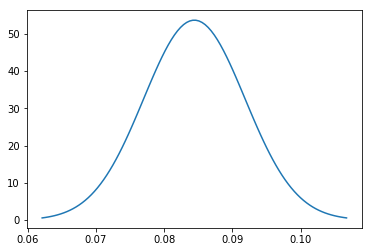

In [254]:
mu = np.average(out)
variance = np.var(out)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

In [256]:
variance

5.521572252206104e-05

In [221]:
df_out.append(df_subset).append(df_subset)

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
225943  1147568    1388564    10000.0      10000.0          10000.0   
225943  1147568    1388564    10000.0      10000.0          10000.0   

              term  int_rate  installment grade sub_grade    ...    inq_fi  \
225943   36 months     15.81       350.64     C        C4    ...       NaN   
225943   36 months     15.81       350.64     C        C4    ...       NaN   

       total_cu_tl inq_last_12m  issue_yr issue_mo last_pymnt_yr  \
225943         NaN          NaN      2012        2          2013   
225943         NaN          NaN      2012        2          2013   

       last_pymnt_mo loan_status_flag mo_diff avg_pymnt  
225943            12                1    22.0     579.2  
225943            12                1    22.0     579.2  

[2 rows x 81 columns]

In [170]:
df_subset.loc[227572]
####MAKE A TABLUARRRR from random table
### risk-adj return /// features 


id                                                                     1120146
member_id                                                              1358165
loan_amnt                                                                25000
funded_amnt                                                              25000
funded_amnt_inv                                                          25000
term                                                                 36 months
int_rate                                                                 16.29
installment                                                             882.51
grade                                                                        D
sub_grade                                                                   D1
emp_title                                                         Patton's Inc
emp_length                                                             6 years
home_ownership                                      

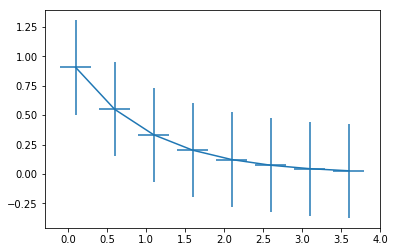

In [401]:
####Confidence Intervals on IRR of overall market
df_conf_int = df_filtered.groupby(['issue_yr'])['irr'].describe()
# example data
x = df_conf_int.index
y = df_conf_int.mean
yerr = df_conf_int.std

fig, ax = plt.subplots()
ax.errorbar(x, y, xerr=0.2, yerr=0.4)
plt.show()








In [ ]:
####DO A POOLED T-TEST of NEW PORTFOLIO vs RANdOM PORTFOLIO

In [ ]:
###appendix

##limitation of individual IRR